# 1 提出问题

**核心价值观：**  
1. 评估各城市的雾霾情况
2. 为普通居民提供防霾预警（TODO: 选择恰当的模型）

**一分钟故事：**  Dolly 是一名项目经理，她经常穿梭于各个城市。Dolly 希望能得到及时的雾霾预警，以便提前做好准备。

# 2.1 数据探查

1. 本数据包含北京、成都、上海、沈阳、广州五城市2010/1/1-2015/12/31的PM2.5以及气象数据，各列含义如下：
> No: 序号  
> year: 年份  
> month: 月份  
> season: 季节  
> PM: PM2.5浓度  
> DEWP(露点): 水蒸气与水达到平衡的温度，用来计算引擎结冰以及出现雾的可能性  
> TEMP: 摄氏温度  
> HUMI: 湿度（%）  
> PRES: 气压（hPa）  
> cbwd: 组合风向  
> lws: 累计风速（m/s）  
> precipitation: 降水量（mm/h）  
> lprec: 累计降水量（mm）  

2. 各个站点间的 pm2.5 浓度接近，各城市间北京的空气质量最差
3. PM_US_Post 列的缺失值最少，适合做分析

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

**导入数据**

In [28]:
data_bj = pd.read_csv('C:/Users/Wang/datasets/pm25-data-for-five-chinese-cities/BeijingPM20100101_20151231.csv')
data_gz = pd.read_csv('C:/Users/Wang/datasets/pm25-data-for-five-chinese-cities/GuangzhouPM20100101_20151231.csv')
data_cd = pd.read_csv('C:/Users/Wang/datasets/pm25-data-for-five-chinese-cities/ChengduPM20100101_20151231.csv')
data_sh = pd.read_csv('C:/Users/Wang/datasets/pm25-data-for-five-chinese-cities/ShanghaiPM20100101_20151231.csv')
data_sy = pd.read_csv('C:/Users/Wang/datasets/pm25-data-for-five-chinese-cities/ShenyangPM20100101_20151231.csv')

**数据预处理**

In [29]:
seasons = {1: 'Spring', 2: 'Summer', 3: 'Autumn', 4: 'Winter'}
months = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 
          7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

In [30]:
data_bj.columns = [item.replace(' ', '_') for item in data_bj.columns]  # 将列名中的空格替换为下划线 
data_bj.season = data_bj.season.map(seasons)  # 将标签值转换为标签
data_bj.month = data_bj.month.map(months)
data_bj.head()

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US_Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,January,1,0,Winter,NaN,NaN,NaN,NaN,-21.0,43.0,1021.0,-11.0,NW,1.79,0.0,0.0
1,2,2010,January,1,1,Winter,NaN,NaN,NaN,NaN,-21.0,47.0,1020.0,-12.0,NW,4.92,0.0,0.0
2,3,2010,January,1,2,Winter,NaN,NaN,NaN,NaN,-21.0,43.0,1019.0,-11.0,NW,6.71,0.0,0.0
3,4,2010,January,1,3,Winter,NaN,NaN,NaN,NaN,-21.0,55.0,1019.0,-14.0,NW,9.84,0.0,0.0
4,5,2010,January,1,4,Winter,NaN,NaN,NaN,NaN,-20.0,51.0,1018.0,-12.0,NW,12.97,0.0,0.0


**数据探查**

In [31]:
data_bj.isna().sum()  # 探查缺失值

No                     0
year                   0
month                  0
day                    0
hour                   0
season                 0
PM_Dongsi          27532
PM_Dongsihuan      32076
PM_Nongzhanguan    27653
PM_US_Post          2197
DEWP                   5
HUMI                 339
PRES                 339
TEMP                   5
cbwd                   5
Iws                    5
precipitation        484
Iprec                484
dtype: int64

In [32]:
data_bj.reindex(columns=['PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan', 'PM_US_Post']).describe()  # 对数据进行描述统计

,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US_Post
count,25052.000000,20508.000000,24931.000000,50387.000000
mean,89.154439,92.560806,88.643737,95.904241
std,87.239267,88.027434,88.041166,91.643772
min,3.000000,3.000000,3.000000,1.000000
25%,24.000000,28.000000,24.000000,27.000000
50%,64.000000,68.000000,62.000000,69.000000
75%,124.000000,127.000000,122.000000,132.000000
max,737.000000,672.000000,844.000000,994.000000


In [33]:
data_gz.columns = [item.replace(' ', '_') for item in data_gz.columns]
data_gz.season = data_gz.season.map(seasons)
data_gz.month = data_gz.month.map(months)
data_gz.head()

,No,year,month,day,hour,season,PM_City_Station,PM_5th_Middle_School,PM_US_Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,January,1,0,Winter,NaN,NaN,NaN,9.4,76.0,1015.1,13.5,NW,0.8,0.0,0.0
1,2,2010,January,1,1,Winter,NaN,NaN,NaN,10.2,83.0,1015.2,13.0,cv,0.5,0.0,0.0
2,3,2010,January,1,2,Winter,NaN,NaN,NaN,10.4,87.0,1015.0,12.5,NW,0.6,0.3,0.3
3,4,2010,January,1,3,Winter,NaN,NaN,NaN,10.2,89.0,1014.9,12.0,NW,1.4,0.6,0.9
4,5,2010,January,1,4,Winter,NaN,NaN,NaN,10.4,91.0,1014.6,11.8,NE,0.6,0.7,1.6


In [34]:
data_gz.isna().sum()

No                          0
year                        0
month                       0
day                         0
hour                        0
season                      1
PM_City_Station         20232
PM_5th_Middle_School    31489
PM_US_Post              20232
DEWP                        1
HUMI                        1
PRES                        1
TEMP                        1
cbwd                        1
Iws                         1
precipitation               1
Iprec                       1
dtype: int64

In [35]:
data_gz.reindex(columns=['PM_City_Station', 'PM_5th_Middle_School', 'PM_US_Post']).describe()

,PM_City_Station,PM_5th_Middle_School,PM_US_Post
count,32352.000000,21095.000000,32352.000000
mean,50.803938,49.064138,50.803938
std,36.927474,30.677967,36.927474
min,1.000000,2.000000,1.000000
25%,24.000000,28.000000,24.000000
50%,43.000000,42.000000,43.000000
75%,68.000000,62.000000,68.000000
max,526.000000,940.000000,526.000000


In [36]:
data_cd.columns = [item.replace(' ', '_') for item in data_cd.columns]
data_cd.season = data_cd.season.map(seasons)
data_cd.month = data_cd.month.map(months)
data_cd.head()

,No,year,month,day,hour,season,PM_Caotangsi,PM_Shahepu,PM_US_Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,January,1,0,Winter,NaN,NaN,NaN,4.0,81.20,1022.0,7.0,cv,1.0,0.0,0.0
1,2,2010,January,1,1,Winter,NaN,NaN,NaN,4.0,86.99,1022.0,6.0,cv,1.0,0.0,0.0
2,3,2010,January,1,2,Winter,NaN,NaN,NaN,4.0,86.99,1021.0,6.0,cv,1.0,0.0,0.0
3,4,2010,January,1,3,Winter,NaN,NaN,NaN,3.0,86.89,1021.0,5.0,cv,1.0,0.0,0.0
4,5,2010,January,1,4,Winter,NaN,NaN,NaN,2.0,86.79,1021.0,4.0,cv,1.0,0.0,0.0


In [37]:
data_cd.isna().sum()

No                   0
year                 0
month                0
day                  0
hour                 0
season               0
PM_Caotangsi     28164
PM_Shahepu       27990
PM_US_Post       23684
DEWP               529
HUMI               535
PRES               521
TEMP               527
cbwd               521
Iws                533
precipitation     2955
Iprec             2955
dtype: int64

In [38]:
data_cd.reindex(columns=['PM_Caotangsi', 'PM_Shahepu', 'PM_US_Post']).describe()

,PM_Caotangsi,PM_Shahepu,PM_US_Post
count,24420.000000,24594.000000,28900.000000
mean,77.507002,75.555867,83.407612
std,60.150955,60.337735,57.239585
min,3.000000,1.000000,1.000000
25%,37.000000,35.000000,44.000000
50%,60.000000,57.000000,68.000000
75%,99.000000,97.000000,105.000000
max,662.000000,573.000000,688.000000


In [39]:
data_sh.columns = [item.replace(' ', '_') for item in data_sh.columns]
data_sh.season = data_sh.season.map(seasons)
data_sh.month = data_sh.month.map(months)
data_sh.head()

,No,year,month,day,hour,season,PM_Jingan,PM_US_Post,PM_Xuhui,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,January,1,0,Winter,NaN,NaN,NaN,-6.0,59.48,1026.1,1.0,cv,1.0,0.0,0.0
1,2,2010,January,1,1,Winter,NaN,NaN,NaN,-6.0,59.48,1025.1,1.0,SE,2.0,0.0,0.0
2,3,2010,January,1,2,Winter,NaN,NaN,NaN,-7.0,59.21,1025.1,0.0,SE,4.0,0.0,0.0
3,4,2010,January,1,3,Winter,NaN,NaN,NaN,-6.0,63.94,1024.0,0.0,SE,5.0,0.0,0.0
4,5,2010,January,1,4,Winter,NaN,NaN,NaN,-6.0,63.94,1023.0,0.0,SE,8.0,0.0,0.0


In [40]:
data_sh.isna().sum()

No                   0
year                 0
month                0
day                  0
hour                 0
season               0
PM_Jingan        27884
PM_US_Post       18545
PM_Xuhui         27395
DEWP                13
HUMI                13
PRES                28
TEMP                13
cbwd                12
Iws                 12
precipitation     4009
Iprec             4009
dtype: int64

In [41]:
data_sh.reindex(columns=['PM_Jingan', 'PM_Xuhui', 'PM_US_Post']).describe()

,PM_Jingan,PM_Xuhui,PM_US_Post
count,24700.000000,25189.000000,34039.000000
mean,57.395992,57.678987,52.910544
std,47.616179,48.412620,42.576138
min,1.000000,1.000000,1.000000
25%,26.000000,26.000000,26.000000
50%,44.000000,43.000000,41.000000
75%,73.000000,73.000000,67.000000
max,635.000000,636.000000,730.000000


In [42]:
data_sy.columns = [item.replace(' ', '_') for item in data_sy.columns]
data_sy.season = data_sy.season.map(seasons)
data_sy.month = data_sy.month.map(months)
data_sy.head()

,No,year,month,day,hour,season,PM_Taiyuanjie,PM_US_Post,PM_Xiaoheyan,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,January,1,0,Winter,NaN,NaN,NaN,-26.0,69.79,1024.0,-22.0,NE,1.0289,NaN,NaN
1,2,2010,January,1,1,Winter,NaN,NaN,NaN,-26.0,76.26,1024.0,-23.0,NE,2.5722,NaN,NaN
2,3,2010,January,1,2,Winter,NaN,NaN,NaN,-27.0,69.56,1023.0,-23.0,NE,5.1444,NaN,NaN
3,4,2010,January,1,3,Winter,NaN,NaN,NaN,-27.0,69.56,1023.0,-23.0,NE,7.7166,NaN,NaN
4,5,2010,January,1,4,Winter,NaN,NaN,NaN,-27.0,69.56,1022.0,-23.0,NE,9.7744,NaN,NaN


In [43]:
data_sy.isna().sum()

No                   0
year                 0
month                0
day                  0
hour                 0
season               0
PM_Taiyuanjie    28196
PM_US_Post       30904
PM_Xiaoheyan     27957
DEWP               692
HUMI               680
PRES               692
TEMP               692
cbwd               692
Iws                692
precipitation    12763
Iprec            12763
dtype: int64

In [44]:
data_sy.reindex(columns=['PM_Taiyuanjie', 'PM_Xiaoheyan', 'PM_US_Post']).describe()

,PM_Taiyuanjie,PM_Xiaoheyan,PM_US_Post
count,24388.000000,24627.000000,21680.00000
mean,81.189683,75.240468,75.83750
std,80.112376,78.404401,68.99593
min,1.000000,2.000000,1.00000
25%,32.000000,28.000000,31.00000
50%,59.000000,51.000000,57.00000
75%,103.000000,93.000000,97.00000
max,1528.000000,1361.000000,932.00000


# 2.2 数据整理

**数据聚合**

In [45]:
citys = ['Beijing', 'Shanghai', 'Chengdu', 'Shenyang', 'Guangzhou']
data_citys = [data_bj, data_sh, data_cd, data_sy, data_gz]
out_columns = ['No', 'year', 'month', 'day', 'hour', 'season', 'PM_US_Post', 'city']
data = DataFrame(columns=out_columns)

In [46]:
for c, d in zip(citys, data_citys):
    temp = d.reindex(columns=out_columns)
    temp.city = c
    data = data.append(temp, ignore_index=True)  # 拼接数据

In [47]:
data.head()

,No,year,month,day,hour,season,PM_US_Post,city
0,1,2010,January,1,0,Winter,NaN,Beijing
1,2,2010,January,1,1,Winter,NaN,Beijing
2,3,2010,January,1,2,Winter,NaN,Beijing
3,4,2010,January,1,3,Winter,NaN,Beijing
4,5,2010,January,1,4,Winter,NaN,Beijing


**数据筛选**

In [48]:
def filter_data(data, condition):
    '''
    返回符合条件的数据
    
    condition 应当符合如下格式：
    '<field> <op> <value>'
    
    并且仅允许如下操作符：
    >, <, ==, >=, <=, !=
    
    例如：
    'city == "Beijing"'
    '''
    
    field, op, value = condition.split(' ', maxsplit=2)  # 最多只分割两次
    
    # 检查 field 是否合法
    if field not in data.columns.values:
        raise Exception("%s is not in DataFrame" % field)
        
    # 将 value 转换为数值或去掉首尾的多余字符
    try:
        value = float(value)
    except:
        value = value.strip(' ')
        value = value.strip("\'\"")
    
    #  获取布尔值进行过滤
    if op == '>':
        matches = data[field] > value
    elif op == '<':
        matches = data[field] < value
    elif op == '==':
        matches = data[field] == value
    elif op == '>=':
        matches = data[field] >= value
    elif op == '<=':
        matches = data[field] <= value
    elif op == '!=':
        matches = data[field] != value
        
    # 过滤数据并返回
    result = data[matches].reset_index(drop=True)
    
    return result

In [140]:
def reading_stats(data, conditions=[], verbose=True):
    '''
    返回符合条件的数据统计结果
    
    例如：['city == "Beijing"', 'PM_US_Post > 120']
    '''
    
    # 过滤数据
    for condition in conditions:
        data = filter_data(data, condition)
        
    # 描述统计
    stats = data.describe()
        
    # 返回统计结果
    if verbose:
        if conditions:
            print('共有%s条数据符合筛选结果' % len(data))
        else:
            print('数据集中共有%s条数据' % len(data))
        
        # 描述统计结果
        print('均值：%.2f' % stats.loc['mean'])
        print('中位数：%.2f' % stats.loc['50%'])
        print('标准差：%.2f' % stats.loc['std'])
        print('峰度：%.2f' % data['PM_US_Post'].kurt())
        print('偏度：%.2f' % data['PM_US_Post'].skew())
        print('下四分位数：%.2f' % stats.loc['25%'])
        print('上四分位数：%.2f' % stats.loc['75%'])
        
#         # 绘制箱线图
#         sns.boxplot(data['PM_US_Post'], showfliers=False)
#         plt.title('Boxplot of pm2.5 of filtered data')
#         plt.xlabel('PM_US Post (ug/m^3)')
        
        # 绘制直方图
        x = data.PM_US_Post.dropna()
        sns.distplot(x, kde=True)
        plt.title('Distplot of pm2.5 of filtered data')
        plt.xlabel('PM_US_Post (ug/m^3)')
    
    return data

共有52584条数据符合筛选结果
均值：95.90
中位数：69.00
标准差：91.64
峰度：5.06
偏度：1.87
下四分位数：27.00
上四分位数：132.00


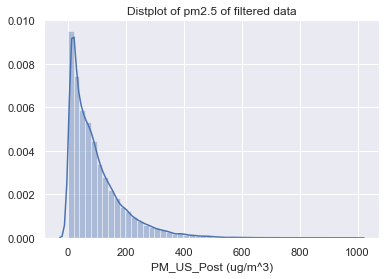

In [151]:
data_filtered_bj = reading_stats(data, ['city == "Beijing"', ])

共有52584条数据符合筛选结果
均值：52.91
中位数：41.00
标准差：42.58
峰度：13.80
偏度：2.58
下四分位数：26.00
上四分位数：67.00


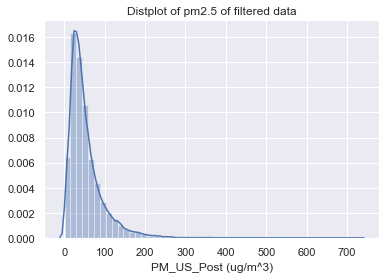

In [152]:
data_filtered_sh = reading_stats(data, ['city == "Shanghai"', ])

共有52584条数据符合筛选结果
均值：75.84
中位数：57.00
标准差：69.00
峰度：16.73
偏度：2.96
下四分位数：31.00
上四分位数：97.00


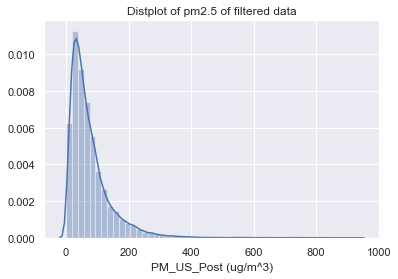

In [153]:
data_filtered_sy = reading_stats(data, ['city == "Shenyang"', ])

共有52584条数据符合筛选结果
均值：83.41
中位数：68.00
标准差：57.24
峰度：4.41
偏度：1.73
下四分位数：44.00
上四分位数：105.00


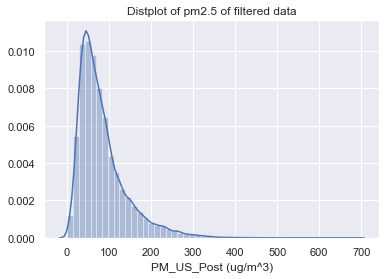

In [154]:
data_filtered_cd = reading_stats(data, ['city == "Chengdu"', ])

共有52584条数据符合筛选结果
均值：50.80
中位数：43.00
标准差：36.93
峰度：5.94
偏度：1.77
下四分位数：24.00
上四分位数：68.00


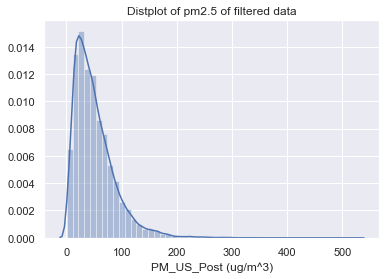

In [155]:
data_filtered_gz = reading_stats(data, ['city == "Guangzhou"', ])

**数据分组**

In [58]:
data.groupby(['city', 'month']).agg(['mean', 'median']).loc['Beijing']['PM_US_Post']

,mean,median
month,,
April,82.887539,69.0
August,73.651066,64.0
December,108.950727,62.0
February,120.994306,84.0
January,113.771130,69.0
July,87.612124,71.0
June,89.389335,76.0
March,96.360909,70.0
May,76.669809,66.0


# 3 探索性数据分析